# Build an expected goals model
This expected goals model is built using David Sumpter's [tutorial](https://www.youtube.com/watch?v=bpjLyFyLlXs&t=599s) and [code](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython)

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
from metrica_football_func import Metrica_Viz as mviz

## Import Wyscout data
You can find the dataset [here](https://figshare.com/collections/Soccer_match_event_dataset/4415000/2).

In [3]:
with open('data_inputs/Wyscout/events/events_England.json') as f:
    data = json.load(f)

## Adapt the data

In [4]:
train = pd.DataFrame(data)
pd.unique(train['subEventName'])
shots=train[train['subEventName']=='Shot']
shots_model=pd.DataFrame(columns=['Goal','X','Y'])

In [5]:
#Go through the dataframe and calculate X, Y co-ordinates.
#Distance from a line in the centre
#Shot angle.
#Details of tags can be found here: https://apidocs.wyscout.com/matches-wyid-events
for i,shot in shots.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*106/100
        y=shots_model.at[i,'C']*68/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1

## Explore the data

In [6]:
H_Shot=np.histogram2d(shots_model['X'], shots_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_model[shots_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])

### Number of shots from different points

In [7]:
import importlib
importlib.reload(mviz)

<module 'metrica_football_func.Metrica_Viz' from '/Users/gabin/Ordinateur/Documents/Informatique/experiments/metrica_football_func/Metrica_Viz.py'>

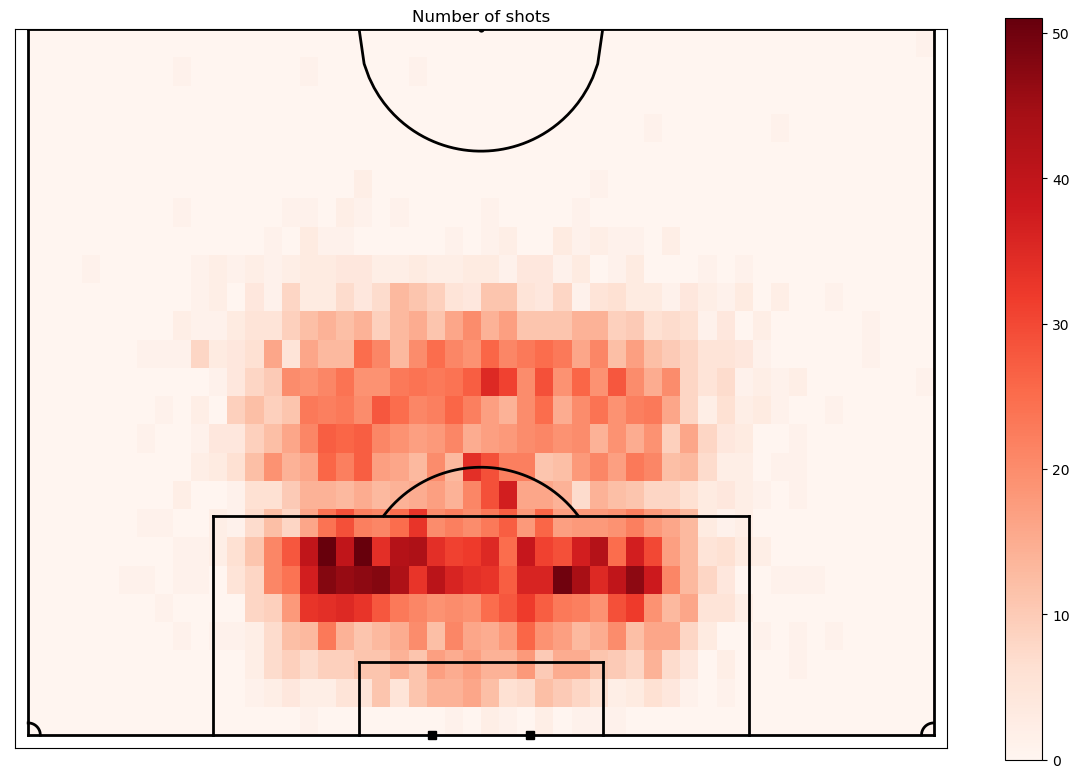

In [8]:
fig,ax=mviz.plot_pitch(field_dimen = (106.0,68.0), half=True, field_color ='white')
pos=ax.imshow(H_Shot[0], extent=[-34,34,53,-53], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-35,35))
plt.ylim((-54,0))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')

## Expected goals model

In [9]:
model_variables = ['Angle','Distance']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]


#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

#Return xG value for more general model
def calculate_xG(sh):    
    bsum=b[0]
    for i,v in enumerate(model_variables):
        bsum=bsum+b[i+1]*sh[v]
    xG = 1/(1+np.exp(bsum)) 
    return xG   

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7131
Model Family:                    Binomial   Df Model:                            2
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1990.3
Date:                    Sun, 10 May 2020   Deviance:                       3980.5
Time:                            23:08:31   Pearson chi2:                 9.21e+03
No. Iterations:                         7                                         
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [10]:
x = 10
y = 5
a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
if a<0:
    a=np.pi+a
shot={'Distance':np.sqrt(x**2 + y**2),'Angle':a}
calculate_xG(shot)

0.2059611557934051

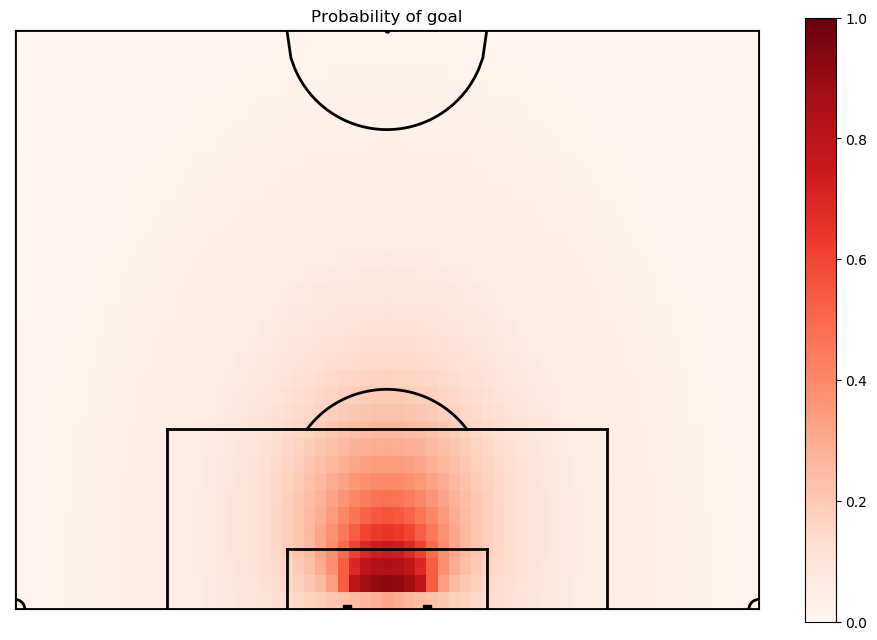

In [13]:
#Add an xG to my dataframe
xG=shots_model.apply(calculate_xG, axis=1) 
shots_model = shots_model.assign(xG=xG)


#Create a 2D map of xG
pgoal_2d=np.zeros((68,68))
for x in range(68):
    for y in range(68):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-68/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        
        pgoal_2d[x,y] =  calculate_xG(sh)

fig,ax=mviz.plot_pitch(field_dimen = (106.0,68.0), half=True, field_color ='white')
pos=ax.imshow(pgoal_2d, extent=[-35,34,53,-53], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=1)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((-34,34))
plt.ylim((-53,0))
plt.gca().set_aspect('equal', adjustable='box')

In [12]:
np.max(pgoal_2d)

0.9152804605744939